# Test No. 1 For Best Results

Finished after steps: 8

*** Episode 0 ***                       
Av.reward: [last 10]: 1.50, [last 100]: 0.15, [all]: 15.00                       
epsilon: 0.98, frames_total: 15
Elapsed time:  00:00:00

*** Episode 10 ***                       
Av.reward: [last 10]: 39.60, [last 100]: 4.11, [all]: 37.36                       
epsilon: 0.67, frames_total: 411
Elapsed time:  00:00:00

*** Episode 20 ***                       
Av.reward: [last 10]: 169.20, [last 100]: 21.03, [all]: 100.14                       
epsilon: 0.16, frames_total: 2103
Elapsed time:  00:00:02

*** Episode 30 ***                       
Av.reward: [last 10]: 1125.70, [last 100]: 133.60, [all]: 430.97                       
epsilon: 0.05, frames_total: 13360
Elapsed time:  00:00:15
SOLVED! After 35 episodes 

*** Episode 40 ***                       
Av.reward: [last 10]: 1093.50, [last 100]: 242.95, [all]: 592.56                       
epsilon: 0.05, frames_total: 24295
Elapsed time:  00:00:31

*** Episode 50 ***

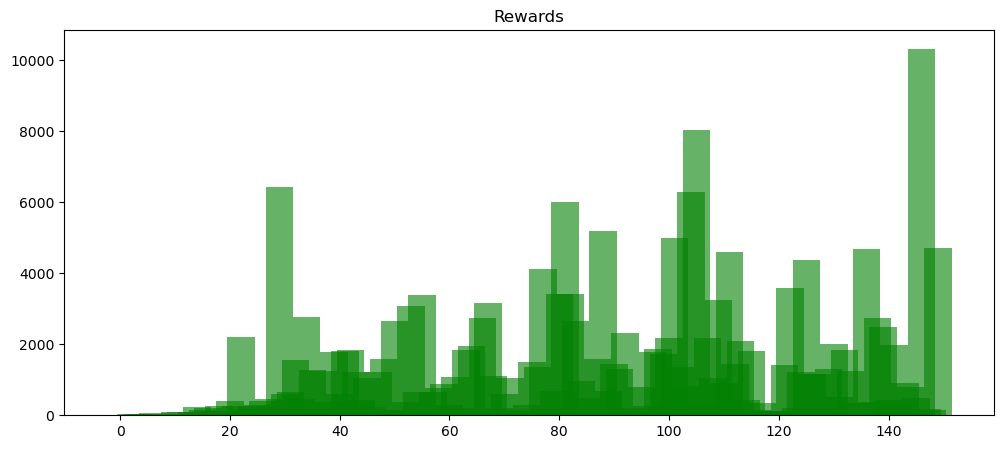

Finished after steps: 331
Finished after steps: 324
Finished after steps: 318
Finished after steps: 331
Finished after steps: 322
Finished after steps: 327
Finished after steps: 322
Finished after steps: 328
Finished after steps: 327
Finished after steps: 325


In [1]:
import torch                         
import torch.nn as nn                
import torch.optim as optim          
import gym                           
import random                        
import math                          
import time                          

import matplotlib.pyplot as plt       

use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor
LongTensor = torch.LongTensor

env = gym.make('CartPole-v1')

seed_value = 23
torch.manual_seed(seed_value)
random.seed(seed_value)


learning_rate = 0.01
num_episodes = 150
gamma = 0.99

hidden_layer = 128

replay_mem_size = 100000
batch_size = 64

egreedy = 0.99
egreedy_final = 0.05
egreedy_decay = 1000

report_interval = 10
score_to_solve = 195

number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n 

def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

class NeuralNetwork(nn.Module): 
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer) 
        self.linear2 = nn.Linear(hidden_layer,number_of_outputs) 
        self.activation = nn.Tanh()
        #self.activation = nn.ReLU()
             
    def forward(self, x):
        output1 = self.linear1(x) 
        output1 = self.activation(output1)
        output2 = self.linear2(output1)

        return output2
  
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.loss_func = nn.MSELoss()      
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)

        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon: 
            
            with torch.no_grad(): 
                
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state) 
                action = torch.max(action_from_nn,0)[1]
                action = action.item()
        else:
            action = env.action_space.sample()
        
        return action
    
    def optimize(self):
        
        if (len(memory) < batch_size):
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state = Tensor(state).to(device) 
        new_state = Tensor(new_state).to(device)
        reward = Tensor(reward).to(device)
        action = LongTensor(action).to(device)
        done = Tensor(done).to(device)

        new_state_values = self.nn(new_state).detach()
        max_new_state_values = torch.max(new_state_values, 1)[0]
        target_value = reward + ( 1 - done ) * gamma * max_new_state_values
  
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
 
class ExperienceReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
 
    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)
        
        if self.position >= len(self.memory): 
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        self.position = ( self.position + 1 ) % self.capacity
        
        
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))
        
        
    def __len__(self):
        return len(self.memory)
        

memory = ExperienceReplay(replay_mem_size)
qnet_agent = QNet_Agent()
qnet_agent.nn.eval()
env = gym.make('CartPole-v1', render_mode = 'human')
for episode in range(10):
    state, _ = env.reset()
    time.sleep(1.) 
    for step in range(10000):
        env.render() 
        time.sleep(0.02) 
        action = qnet_agent.select_action(state, 0)
        new_state, reward, done, _, _ = env.step(action)
        state = new_state
        if done:
            print('Finished after steps:', step)
            break
    
    break
env.close()
env.env.close()

env = gym.make('CartPole-v1')

qnet_agent.nn.train()

steps_total = [] 

frames_total = 0 
solved_after = 0 
solved = False

start_time = time.time()

for i_episode in range(num_episodes):

    state, _ = env.reset()
    
    step = 0 

    while True: 
        
        step += 1 
        frames_total += 1 
        
        epsilon = calculate_epsilon(frames_total) 
        
        #action = env.action_space.sample()
        action = qnet_agent.select_action(state, epsilon) 
        
        new_state, reward, done, _, _ = env.step(action) 

        memory.push(state, action, new_state, reward, done) 
        qnet_agent.optimize() 
        
        state = new_state 
         
        if done: 
            steps_total.append(step) 
            
            mean_reward_100 = sum(steps_total[-100:])/100
            
            if (mean_reward_100 > score_to_solve and solved == False):
                print("SOLVED! After %i episodes " % i_episode)
                solved_after = i_episode
                solved = True
            
            if (i_episode % report_interval == 0):
                
                
                
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, frames_total: %i" 
                  % 
                  ( i_episode,
                    report_interval,
                    sum(steps_total[-report_interval:])/report_interval,
                    mean_reward_100,
                    sum(steps_total)/len(steps_total),
                    epsilon,
                    frames_total
                          ) 
                  ) 
                  
                elapsed_time = time.time() - start_time
                print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))



            break
        
state_dict = qnet_agent.nn.state_dict()
torch.save(state_dict, 'dqn_er_best4.pth')


print("\n\n\n\nAverage reward: %.2f" % (sum(steps_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
if solved:
    print("Solved after %i episodes" % solved_after)
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green', width=5)
plt.show()


env.close()
env.env.close()


state_dict = torch.load('dqn_er_best4.pth')
qnet_agent.nn.load_state_dict(state_dict)
qnet_agent.nn.eval()
env = gym.make('CartPole-v1', render_mode = 'human')
for episode in range(10):
    state, _ = env.reset()
    time.sleep(1.) 
    for step in range(10000):
        env.render() 
        time.sleep(0.02) 
        action = qnet_agent.select_action(state, 0)
        new_state, reward, done, _, _ = env.step(action)
        state = new_state
        if done:
            print('Finished after steps:', step)
            break
env.close()
env.env.close()


# Explanation of Results

Key points from results:

The algorithm solved the problem after 35 episodes, which is incredibly fast.
The average reward across all episodes was 1330.33.
The average reward across the last 100 episodes was 1657.47.

Comparing with the intial test:

This test results solved the problem in fewer episodes (35 compared to 66), indicating that the algorithm performed better.
The second set of results had a higher average reward across all episodes (1330.33 compared to 383.64), indicating that the algorithm performed better overall.

This set of results also had a higher average reward across the last 100 episodes (1657.47 compared to 383.64), indicating that the algorithm's performance continued to improve over time.

In summary, the second set of results shows that the algorithm performed better and was able to solve the problem more efficiently than the first set of results. It had higher average rewards across all episodes and the last 100 episodes, and it required fewer episodes to solve the problem.